In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import time
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error

In [2]:
# uncomment following line to download TTM
# ! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.12"

In [2]:
stock_symbols = [
    "RIVN",  # Rivian Automotive
    "TSLA",  # Tesla
    "NIO",   # Nio Inc ADR
    "XPEV",  # Xpeng Inc ADR
    "EVGO",  # Evgo Inc
    "LI",    # Li Auto Inc ADR
    "INDI",  # Indie Semiconductor Inc Class A
    "CHPT",  # Chargepoint Holdings Inc Class A
    "LCID",  # Lucid Group Inc
    "LAZR"   # Luminar Technologies Inc Class A
]
train_raw = yf.download(stock_symbols, start='2024-01-01', end='2024-08-31')['Close']
train_length = len(train_raw)
test = yf.download(stock_symbols, start='2024-09-01', end='2024-09-30')['Close']
test_length = len(test)
train_test_raw = pd.concat([train_raw, test])
train_test_raw = train_test_raw.join(train_test_raw.pct_change(), rsuffix = '_pct_change').dropna().reset_index()
train_length += -1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


In [3]:
def preprocess(data, freq):
    #scaler = StandardScaler()
    rft = np.fft.rfft(data)
    rft[freq:] = 0
    smooth = np.fft.irfft(rft, n=len(data)) 
    smooth[:2], smooth[-2:] = data.iloc[:2], data.iloc[-2:]
    #smooth = scaler.fit_transform(smooth.reshape(-1, 1))
    return smooth

In [4]:
%%time
from tsfm_public import TimeSeriesForecastingPipeline, TinyTimeMixerForPrediction
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1", revision = 'main', num_input_channels=1
)
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column='Date',
    target_columns=['Target'],
    explode_forecasts=True,
    freq="B",
    id_columns=[],
)

pred_ttm_day_pct = {}
pred_ttm_week_pct = {}
for x in stock_symbols:
    pred_day = []
    pred_week = []
    for y in range(test_length):
        #freq = -1 means no smoothening
        cur_data = train_test_raw[['Date']].iloc[:train_length + y]
        cur_data['Target'] = preprocess(train_test_raw[f"{x}_pct_change"].iloc[:train_length + y], freq = -1)
        forecast = pipeline(cur_data)['Target_prediction'][0]
        pred_day.append((forecast + 1)*train_test_raw[x].iloc[train_length + y - 1])

        cur_data = train_test_raw[['Date']].iloc[:train_length + y - 5]
        cur_data['Target'] = preprocess(train_test_raw[f"{x}_pct_change"].iloc[:train_length + y - 5], freq = -1)
        forecast = pipeline(cur_data)['Target_prediction'][:5].to_numpy()
        pred_week.append(np.prod(forecast + 1)*train_test_raw[x].iloc[train_length + y - 5])
    pred_ttm_day_pct[x] = pred_day
    pred_ttm_week_pct[x] = pred_week
pred_ttm_day_pct['TSLA']

INFO:p-98936:t-104420:config.py:<module>:PyTorch version 2.5.1 available.


CPU times: total: 16.3 s
Wall time: 8.76 s


[215.96888099994487,
 209.26481710146243,
 220.33997199793015,
 232.71012409299854,
 203.59848903385034,
 216.75173691250944,
 228.10217090618215,
 229.02181557638625,
 230.5810962314872,
 230.68246361234614,
 225.4684178896067,
 227.9451039473695,
 227.24813041105475,
 246.92276991698577,
 236.38706318987533,
 251.39464891981333,
 254.5880432345886,
 257.58084955805737,
 253.84013185228355]

In [5]:
def MASE(actual, predicted, roll, test_length):
    naive_forecast = actual[-test_length - roll: -roll]
    actual = actual[-test_length:]
    return mean_absolute_error(actual, predicted) / mean_absolute_error(actual, naive_forecast), mean_absolute_percentage_error(actual, predicted)

mase_ttm_day_pct = {}
mape_ttm_day_pct = {}
for x in stock_symbols:
    mase_ttm_day_pct[x], mape_ttm_day_pct[x] = MASE(train_test_raw[x], pred_ttm_day_pct[x], 1, test_length)
    print(f"{x}: {mase_ttm_day_pct[x]}")
np.mean(list(mase_ttm_day_pct.values()))

RIVN: 1.1479363215707228
TSLA: 1.1213603490405064
NIO: 1.1094092492061591
XPEV: 1.0834405643670895
EVGO: 1.0109713709526316
LI: 1.0889940486261287
INDI: 1.053652274341958
CHPT: 1.118407020265767
LCID: 1.1042467613335227
LAZR: 1.1665948059153823


1.1005012765619866

In [6]:
mase_ttm_week_pct = {}
mape_ttm_week_pct = {}
for x in stock_symbols:
    mase_ttm_week_pct[x], mape_ttm_week_pct[x] = MASE(train_test_raw[x], pred_ttm_week_pct[x], 5, test_length)
    print(f"{x}: {mase_ttm_week_pct[x]}")
np.mean(list(mase_ttm_week_pct.values()))

RIVN: 1.0209508941506016
TSLA: 1.0963519778070816
NIO: 1.0262123464316397
XPEV: 0.9886643958968293
EVGO: 1.253951387040133
LI: 1.042149057365791
INDI: 1.0886647673569045
CHPT: 1.1529234470519414
LCID: 1.1422356054047293
LAZR: 1.1872908430439861


1.0999394721549638

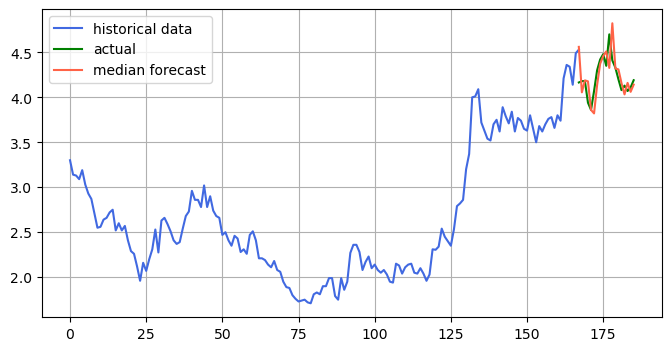

In [7]:
import matplotlib.pyplot as plt
forecast_index = range(train_length, train_length + test_length)
index = 'EVGO'
plt.figure(figsize=(8, 4))
plt.plot(range(len(train_raw)),train_raw[index].values, color="royalblue", label="historical data")
plt.plot(forecast_index, test[index].values, color="green", label="actual")
plt.plot(forecast_index, pred_ttm_day_pct[index], color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

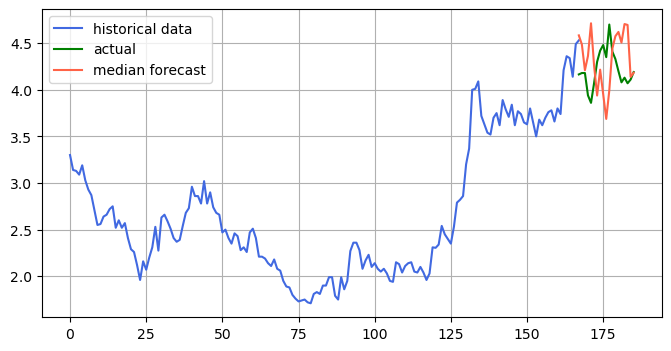

In [8]:
forecast_index = range(train_length, train_length + test_length)
index = 'EVGO'
plt.figure(figsize=(8, 4))
plt.plot(range(len(train_raw)),train_raw[index].values, color="royalblue", label="historical data")
plt.plot(forecast_index, test[index].values, color="green", label="actual")
plt.plot(forecast_index, pred_ttm_week_pct[index], color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

In [9]:
%%time
from tsfm_public import TimeSeriesForecastingPipeline, TinyTimeMixerForPrediction
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1", revision = 'main', num_input_channels=1
)
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column='Date',
    target_columns=['Target'],
    explode_forecasts=True,
    freq="B",
    id_columns=[],
)

pred_ttm_day_true = {}
pred_ttm_week_true = {}
for x in stock_symbols:
    pred_day = []
    pred_week = []
    for y in range(test_length):
        #freq = -1 means no smoothening
        cur_data = train_test_raw[['Date']].iloc[:train_length+ y]
        cur_data['Target'] = preprocess(train_test_raw[x].iloc[:train_length + y], freq = -1)
        forecast = pipeline(cur_data)['Target_prediction'][0]
        pred_day.append(forecast)

        cur_data = train_test_raw[['Date']].iloc[:train_length+ y - 5]
        cur_data['Target'] = preprocess(train_test_raw[x].iloc[:train_length + y - 5], freq = -1)
        forecast = pipeline(cur_data)['Target_prediction'][4]
        pred_week.append(forecast)

    pred_ttm_day_true[x] = pred_day
    pred_ttm_week_true[x] = pred_week
pred_ttm_day_true['TSLA']

CPU times: total: 13.8 s
Wall time: 6.31 s


[220.43553161621094,
 219.40945434570312,
 227.4150390625,
 238.33595275878906,
 216.64715576171875,
 220.19830322265625,
 228.7060089111328,
 230.05072021484375,
 230.68545532226562,
 230.30081176757812,
 226.2882080078125,
 227.31427001953125,
 226.22503662109375,
 245.53390502929688,
 239.84375,
 253.71829223632812,
 258.8570556640625,
 261.549560546875,
 256.38031005859375]

In [10]:
mase_ttm_day_true = {}
mape_ttm_day_true = {}
for x in stock_symbols:
    mase_ttm_day_true[x], mape_ttm_day_true[x] = MASE(train_test_raw[x], pred_ttm_day_true[x], 1, test_length)
    print(f"{x}: {mase_ttm_day_true[x]}")
np.mean(list(mase_ttm_day_true.values()))

RIVN: 1.2359405076336811
TSLA: 0.8669339476486331
NIO: 1.0406607349950558
XPEV: 1.0461768681961325
EVGO: 1.0058220015535895
LI: 1.4890876156048132
INDI: 1.2305003316531806
CHPT: 1.3921327066062592
LCID: 1.0612688001370736
LAZR: 1.5431566588359198


1.1911680172864336

In [11]:
mase_ttm_week_true = {}
mape_ttm_week_true = {}
for x in stock_symbols:
    mase_ttm_week_true[x], mape_ttm_week_true[x] = MASE(train_test_raw[x], pred_ttm_week_true[x], 5, test_length)
    print(f"{x}: {mase_ttm_week_true[x]}")
np.mean(list(mase_ttm_week_true.values()))

RIVN: 1.0978808904918125
TSLA: 1.3135353333002047
NIO: 1.2147658782992807
XPEV: 1.1879233688665014
EVGO: 0.921254747054406
LI: 1.1201814752389179
INDI: 1.2248844928574623
CHPT: 1.0982283845280933
LCID: 0.6959435525957021
LAZR: 1.2430808617522309


1.1117678984984611

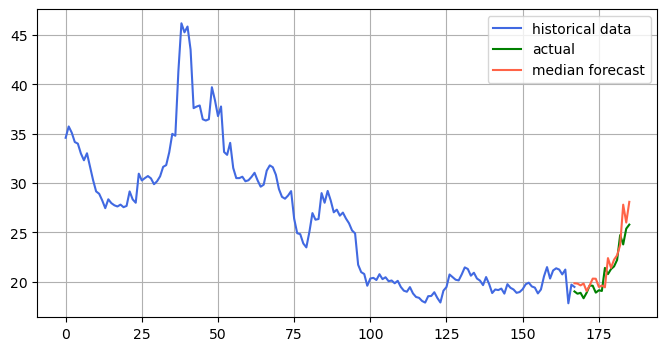

In [12]:
forecast_index = range(train_length, train_length + test_length)
index = 'LI'
plt.figure(figsize=(8, 4))
plt.plot(range(len(train_raw)),train_raw[index].values, color="royalblue", label="historical data")
plt.plot(forecast_index, test[index].values, color="green", label="actual")
plt.plot(forecast_index, pred_ttm_day_true[index], color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

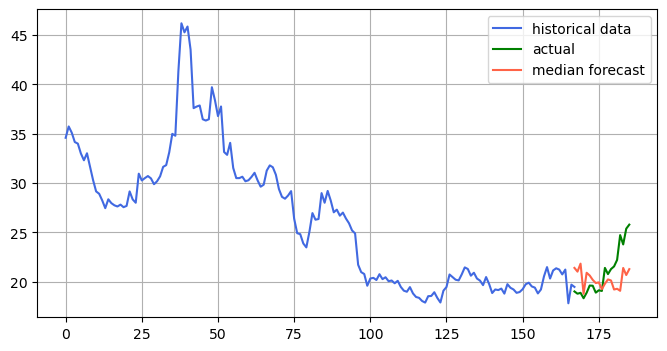

In [13]:
forecast_index = range(train_length, train_length + test_length)
index = 'LI'
plt.figure(figsize=(8, 4))
plt.plot(range(len(train_raw)),train_raw[index].values, color="royalblue", label="historical data")
plt.plot(forecast_index, test[index].values, color="green", label="actual")
plt.plot(forecast_index, pred_ttm_week_true[index], color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

In [14]:
chronos = pd.read_csv('../data/chronos.csv', index_col = 'company')
ltsm = pd.read_csv('../data/ltsm.csv', index_col = 'company')

In [15]:
mase_day = chronos[['mase_chronos_day', 'mase_ets_day']].join(ltsm[['mase_ltsm_day']])
mase_day[['mase_ttm_day_pct', 'mase_ttm_day_true']] = [mase_ttm_day_pct, mase_ttm_day_true]
mase_day.loc['mean'] = mase_day.mean()
mase_day.style.highlight_min(axis=1, props="font-weight:bold;").set_caption("Single Day Prediction Evaluated on MASE")

,mase_chronos_day,mase_ets_day,mase_ltsm_day,mase_ttm_day_pct,mase_ttm_day_true
company,,,,,
RIVN,0.904604,0.981611,1.281811,1.147936,1.235941
TSLA,1.017095,1.017235,1.216340,1.121360,0.866934
NIO,0.987761,1.071334,0.951100,1.109409,1.040661
XPEV,0.958702,0.952207,0.924162,1.083441,1.046177
EVGO,1.044233,1.012554,1.038201,1.010971,1.005822
LI,0.984175,1.023803,1.071164,1.088994,1.489088
INDI,1.052755,0.986060,1.112273,1.053652,1.230500
CHPT,1.163536,1.014226,1.115744,1.118407,1.392133
LCID,0.987955,0.994218,1.079747,1.104247,1.061269


In [16]:
mape_day = chronos[['mape_chronos_day', 'mape_ets_day']].join(ltsm[['mape_ltsm_day']])
mape_day[['mape_ttm_day_pct', 'mape_ttm_day_true']] = [mape_ttm_day_pct, mape_ttm_day_true]
mape_day.loc['mean'] = mape_day.mean()
mape_day.style.highlight_min(axis=1, props="font-weight:bold;").set_caption("Single Day Prediction Evaluated on MAPE")

,mape_chronos_day,mape_ets_day,mape_ltsm_day,mape_ttm_day_pct,mape_ttm_day_true
company,,,,,
RIVN,0.028443,0.030758,0.039871,0.036100,0.038711
TSLA,0.027124,0.027147,0.032735,0.030181,0.023349
NIO,0.049446,0.054046,0.047544,0.055410,0.051940
XPEV,0.039966,0.039561,0.039533,0.045654,0.045224
EVGO,0.034122,0.033268,0.034045,0.033107,0.033177
LI,0.032090,0.033222,0.035618,0.035569,0.049567
INDI,0.047126,0.043712,0.049939,0.046842,0.055396
CHPT,0.051042,0.044696,0.048921,0.048825,0.061137
LCID,0.029440,0.029633,0.031938,0.032762,0.031855


In [17]:
mape_week = chronos[['mape_chronos_week', 'mape_ets_week']]
mape_week[['mape_ttm_week_pct', 'mape_ttm_week_true']] = [mape_ttm_week_pct, mape_ttm_week_true]
mape_week.loc['mean'] = mape_week.mean()
mape_week.style.highlight_min(axis=1, props="font-weight:bold;").set_caption("5 Day Prediction Evaluated on MAPE")

C:\Users\manat\AppData\Local\Temp\ipykernel_98936\687007716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mape_week[['mape_ttm_week_pct', 'mape_ttm_week_true']] = [mape_ttm_week_pct, mape_ttm_week_true]
C:\Users\manat\AppData\Local\Temp\ipykernel_98936\687007716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mape_week[['mape_ttm_week_pct', 'mape_ttm_week_true']] = [mape_ttm_week_pct, mape_ttm_week_true]
C:\Users\manat\AppData\Local\Temp\ipykernel_98936\687007716.py:3: SettingWithCopyWarning: 
A v

,mape_chronos_week,mape_ets_week,mape_ttm_week_pct,mape_ttm_week_true
company,,,,
RIVN,0.076024,0.065585,0.067544,0.072808
TSLA,0.060627,0.062111,0.056981,0.067135
NIO,0.124145,0.144510,0.118010,0.137582
XPEV,0.082215,0.103479,0.092379,0.110182
EVGO,0.073706,0.080124,0.088295,0.064405
LI,0.088831,0.104181,0.089360,0.095027
INDI,0.119837,0.099877,0.111346,0.125366
CHPT,0.182259,0.161699,0.156736,0.150796
LCID,0.060079,0.083699,0.092692,0.056687


In [18]:
mase_week = chronos[['mase_chronos_week', 'mase_ets_week']]
mase_week[['mase_ttm_week_pct', 'mase_ttm_week_true']] = [mase_ttm_week_pct, mase_ttm_week_true]
mase_week.loc['mean'] = mase_week.mean()
mase_week.style.highlight_min(axis=1, props="font-weight:bold;").set_caption("5 Day Prediction Evaluated on MASE")

C:\Users\manat\AppData\Local\Temp\ipykernel_98936\2235523451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mase_week[['mase_ttm_week_pct', 'mase_ttm_week_true']] = [mase_ttm_week_pct, mase_ttm_week_true]
C:\Users\manat\AppData\Local\Temp\ipykernel_98936\2235523451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mase_week[['mase_ttm_week_pct', 'mase_ttm_week_true']] = [mase_ttm_week_pct, mase_ttm_week_true]
C:\Users\manat\AppData\Local\Temp\ipykernel_98936\2235523451.py:3: SettingWithCopyWarning: 


,mase_chronos_week,mase_ets_week,mase_ttm_week_pct,mase_ttm_week_true
company,,,,
RIVN,1.126736,0.979270,1.020951,1.097881
TSLA,1.168331,1.197025,1.096352,1.313535
NIO,1.085391,1.250533,1.026212,1.214766
XPEV,0.890558,1.091671,0.988664,1.187923
EVGO,1.061343,1.136665,1.253951,0.921255
LI,1.054878,1.242454,1.042149,1.120181
INDI,1.133492,0.966679,1.088665,1.224884
CHPT,1.330374,1.189247,1.152923,1.098228
LCID,0.742618,1.018424,1.142236,0.695944


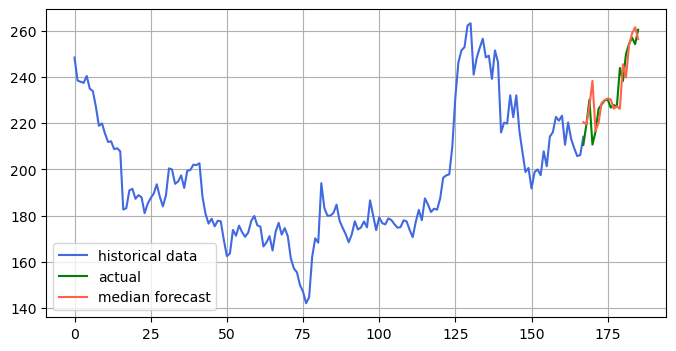

In [19]:
forecast_index = range(train_length, train_length + test_length)
index = 'TSLA'
plt.figure(figsize=(8, 4))
plt.plot(range(len(train_raw)),train_raw[index].values, color="royalblue", label="historical data")
plt.plot(forecast_index, test[index].values, color="green", label="actual")
plt.plot(forecast_index, pred_ttm_day_true[index], color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()